# Predicting GDP using health, population, and nutrition metrics

We are using the Health Nutrition and Population Dataset from Kaggle (https://www.kaggle.com/datasets/theworldbank/health-nutrition-and-population-statistics). For each country and year from 1960-2016, the dataset contains metrics about population dynamics, nutrition, reproductive health, health financing, medical resources and usage, immunization, infectious diseases, HIV/AIDS, DALY, population projections and lending. 
We are using a separate Kaggle dataset to get information about GDP of a country for every year in 1960-2016. Later in the notebook, we join the two.
<br>

We plan on creating models that predict/classify a country's GDP based off of these metrics.

## Data Exploration

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Read CSV file with low_memory=False
nutr_df = pd.read_csv("./data.csv", low_memory=False)
gdp_df = pd.read_csv("./gdp.csv", low_memory=False)

As you can see below, nutr_df (which represents the Health, Population, and Nutrition dataset) contains columns for each year from 1960-2016.
<br>
Each country in the world has around 200 rows. Each row contains data regarding a particular indicator, such as "Cause of death, by non-communicable diseases (% of total)"

In [77]:
nutr_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,...,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
3,Arab World,ARB,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To better understand the indicators we are working with, they are printed below. It is quite impressive how comprehensive this dataset is.

In [79]:
print(nutr_df['Indicator Name'].unique().tolist())

['% of females ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions)', '% of males ages 15-49 having comprehensive correct knowledge about HIV (2 prevent ways and reject 3 misconceptions)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Adults (ages 15+) and children (0-14 years) living with HIV', 'Adults (ages 15+) and children (ages 0-14) newly infected with HIV', 'Adults (ages 15+) living with HIV', 'Adults (ages 15+) newly infected with HIV', 'Age at first marriage, female', 'Age at first marriage, male', 'Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Age population, age 0, female, interpolated', 'Age population, age 0, male, interpolated', 'Age population, age 01, female, interpolated', 'Age population, age 01, male, interpolated', 'Age population, age 02, female, interpolated', 'Age population, age 02, male, interpolated', 'Age population, age 

### Exploring Null Values Per Year

We want to see the distribution of null values across the dataset. 

In [7]:
#get the null counts for each year
null_year_df = pd.DataFrame()
years=[]
null_counts=[]
for year in range(1960, 2016):
  years.append(str(year))
  null_counts.append(nutr_df[str(year)].isna().sum())

null_year_df['year']=years
null_year_df['null_count']=null_counts

/var/folders/3s/6h63ktl15h541pj1y1mgy8vw0000gn/T/ipykernel_57715/794625356.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



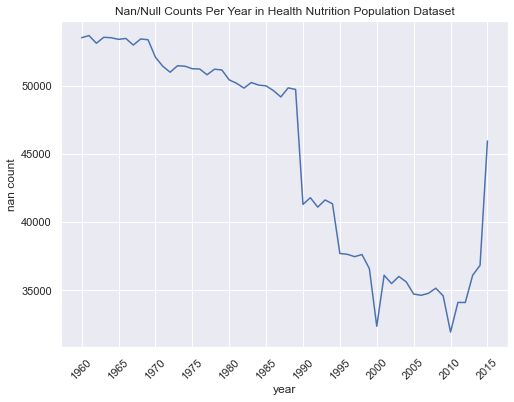

In [81]:
fig, ax = plt.subplots()
sns.lineplot(data=null_year_df, x='year', y='null_count')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%5!=0:
        xticks[i].set_visible(False)
ax.set_xticklabels( years, rotation=45 )  
plt.title('Nan/Null Counts Per Year in Health Nutrition Population Dataset')      
plt.ylabel('nan count')
plt.show()

The graph above indicates that there are a number of null values in the early years, notably before 1987. This makes sense because data collection was not as simple and prevalent prior to the digital age

In [88]:
num_nulls = nutr_df.isna().any(axis=1).sum()
num_nulls

89010

In [13]:
num_dups = nutr_df.duplicated().sum()
num_dups

0

In [92]:
print(num_nulls/len(nutr_df))

1.0


Across all columns, there are 89010 NaNs and 0 duplicates. The number of rows with NaN values is equal to the number of rows in the dataset! Therefore it does not make sense to use dropna() on the dataframe

Some of the indicators are in terms of numbers, not percentages, so we will drop any Indicator name that does not contains the words 'rate', '%', 'per', or 'ratio'.
The reason for doing this is because larger countries will have larger raw numbers for certain metrics, causing incorrect correlations.

In [14]:
nutr_df = nutr_df[(nutr_df['Indicator Name'].str.contains('%')) | (nutr_df['Indicator Name'].str.contains('rate')) | (nutr_df['Indicator Name'].str.contains('per')) | (nutr_df['Indicator Name'].str.contains('ratio'))]
#df = df[df['Indicator Code'].str.contains('rate|per')]


### Pivoting the table
We will pivot the indicators to the columns and years to the rows. 
There are two motivators for pivoting the table like this:
1. 

We are pivoting indicators to columns to make future steps in training the model more straightforward. Having the indicators in columns will allow us to easily project the table to indicators of interest. We are pivoting the years to the rows to make it easier to remove None and Nan values by year rather than by row. In our EDA, we see that most rows contain at least one None/Nan value in the columns of early years since not much data was collected then.

In [15]:
nutr_df.columns
nutr_df.drop("Unnamed: 60", axis=1, inplace=True)

/Users/aashvimanakiwala/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
melt_nutr_df = nutr_df.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"], var_name="Year", value_name="Value")
melt_nutr_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,1960,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,1960,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,133.555013
3,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,87.799235
4,Arab World,ARB,Antiretroviral therapy coverage (% of people l...,SH.HIV.ARTC.ZS,1960,NaN


In [17]:
pivoted_df = melt_nutr_df.pivot_table(index=['Country Code', 'Year'], columns='Indicator Code', values='Value').reset_index()

pivoted_df.head(5)


Indicator Code,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.POP.TOTL.MA.ZS,SP.REG.BRTH.RU.ZS,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.022285,NaN,NaN,NaN,NaN,3.163869,49.224,3.106802,50.776,NaN
1,ABW,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.037612,NaN,NaN,NaN,NaN,2.271351,49.239,2.206183,50.761,NaN
2,ABW,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.032476,NaN,NaN,NaN,NaN,1.447561,49.254,1.386975,50.746,NaN
3,ABW,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.014939,NaN,NaN,NaN,NaN,0.866460,49.270,0.802881,50.730,NaN
4,ABW,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.994371,NaN,NaN,NaN,NaN,0.613827,49.285,0.554748,50.715,NaN


We will also pivot population table.

In [18]:
pivoted_df.head(5)

Indicator Code,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.POP.TOTL.MA.ZS,SP.REG.BRTH.RU.ZS,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.022285,NaN,NaN,NaN,NaN,3.163869,49.224,3.106802,50.776,NaN
1,ABW,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.037612,NaN,NaN,NaN,NaN,2.271351,49.239,2.206183,50.761,NaN
2,ABW,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.032476,NaN,NaN,NaN,NaN,1.447561,49.254,1.386975,50.746,NaN
3,ABW,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.014939,NaN,NaN,NaN,NaN,0.866460,49.270,0.802881,50.730,NaN
4,ABW,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.994371,NaN,NaN,NaN,NaN,0.613827,49.285,0.554748,50.715,NaN


In [19]:
num_null = melt_nutr_df["Value"].isnull().sum()
print("Number of rows where Value is null:", num_null)

Number of rows where Value is null: 1994589


In [20]:
melt_nutr_df.dropna(subset=['Value'], inplace=True)


### Exploring the GDP Dataset

In [82]:
null_year_df_gdp = pd.DataFrame()
years=[]
null_counts=[]
for year in range(1960, 2016):
  years.append(str(year))
  null_counts.append(gdp_df[str(year)].isna().sum())

null_year_df_gdp['year']=years
null_year_df_gdp['null_count']=null_counts

/var/folders/3s/6h63ktl15h541pj1y1mgy8vw0000gn/T/ipykernel_57715/3581963290.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



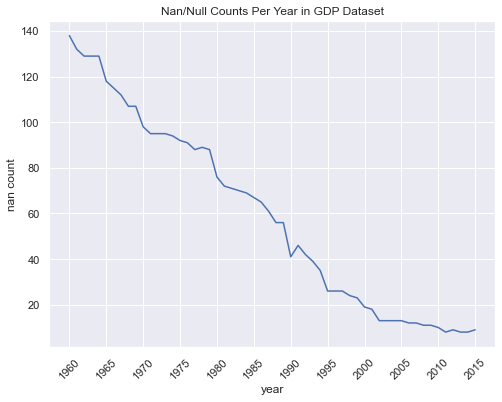

In [83]:
fig, ax = plt.subplots()
sns.lineplot(data=null_year_df_gdp, x='year', y='null_count')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%5!=0:
        xticks[i].set_visible(False)
ax.set_xticklabels( years, rotation=45 )   
plt.title('Nan/Null Counts Per Year in GDP Dataset')      
plt.ylabel('nan count')     
plt.show()

## Correlation Matrix
In the following cells, we will determine which indicators have the greatest impact on a country's GDP. This will be done though by finding the correlation between the GDP and each indicator.

melt_nutr_df does not contain the GDP of the countries, so we will use another dataset on countries and their GDP values by years and join it with melt_nutr_df on country code.

There are a lot of NaN values for some years (earlier ones) was just not collected. We will remove NaN values since there is not a better way to deal with them.
We will also rename the value columns to make it clear which values are from nutritional datasets and which indicate the gdp of the country for the specific year.

pivoting gdp

In [21]:
melt_gdp_df = gdp_df.melt(id_vars=["Country Name", "Code"], var_name="Year", value_name="Value")
melt_gdp_df.head(5)
pivoted_df.head(5)

Indicator Code,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.POP.TOTL.MA.ZS,SP.REG.BRTH.RU.ZS,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.022285,NaN,NaN,NaN,NaN,3.163869,49.224,3.106802,50.776,NaN
1,ABW,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.037612,NaN,NaN,NaN,NaN,2.271351,49.239,2.206183,50.761,NaN
2,ABW,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.032476,NaN,NaN,NaN,NaN,1.447561,49.254,1.386975,50.746,NaN
3,ABW,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.014939,NaN,NaN,NaN,NaN,0.866460,49.270,0.802881,50.730,NaN
4,ABW,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.994371,NaN,NaN,NaN,NaN,0.613827,49.285,0.554748,50.715,NaN


In [22]:
#drop country name because this is available from nutritional dataset
melt_gdp_df = melt_gdp_df.drop(columns=['Country Name'])

In [23]:
#merge the two tables to get country's gdp for the given year
merged_gdp = pd.merge(pivoted_df, melt_gdp_df, left_on=['Country Code', 'Year'], right_on=['Code', 'Year'])
#rename columns
merged_gdp = merged_gdp.rename(columns={'Value': 'gdp_country'})
#get rid of NaN
merged_gdp.dropna(subset=['gdp_country'], inplace=True)


In [24]:
merged_gdp.dtypes

Country Code             object
Year                     object
NY.GNP.PCAP.CD          float64
SE.ADT.1524.LT.FM.ZS    float64
SE.ADT.1524.LT.MA.ZS    float64
                         ...   
SP.URB.GROW             float64
SP.URB.TOTL.IN.ZS       float64
SP.UWT.TFRT             float64
Code                     object
gdp_country             float64
Length: 221, dtype: object

In [25]:
merged_gdp.head(5)


,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT,Code,gdp_country
26,ABW,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.580604,49.620,-0.641159,50.380,NaN,ABW,4.054634e+08
27,ABW,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.269118,49.635,-1.330100,50.365,NaN,ABW,4.876025e+08
28,ABW,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.202958,49.650,-1.263447,50.350,NaN,ABW,5.964236e+08
29,ABW,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.042878,49.665,-0.104112,50.335,NaN,ABW,6.953044e+08
30,ABW,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.843551,49.681,1.780922,50.319,NaN,ABW,7.648871e+08


Some columns contain object types. Specifically, 'Indicator Name'is the columns we are interested in. We will use label encoding to map values to type int so we can use the columns in correlation matrix.

In [26]:
from sklearn.preprocessing import LabelEncoder
#drop because there exists 'Country Code' which is a duplicate
corr_gdp = merged_gdp.drop(columns=['Code'])

In [27]:
le = LabelEncoder()

#fitting encoder on the country codes and transform them to int
corr_gdp['Country Code'] = le.fit_transform(corr_gdp['Country Code'])
corr_gdp.head(5)

,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.REG.BRTH.RU.ZS,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT,gdp_country
26,0,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.580604,49.620,-0.641159,50.380,NaN,4.054634e+08
27,0,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.269118,49.635,-1.330100,50.365,NaN,4.876025e+08
28,0,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.202958,49.650,-1.263447,50.350,NaN,5.964236e+08
29,0,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.042878,49.665,-0.104112,50.335,NaN,6.953044e+08
30,0,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.843551,49.681,1.780922,50.319,NaN,7.648871e+08


In [28]:
correlation_matrix = corr_gdp.corr()["gdp_country"][0:-1]


In [29]:
correlation_matrix.head(5)

Country Code            0.066568
NY.GNP.PCAP.CD          0.202071
SE.ADT.1524.LT.FM.ZS    0.082912
SE.ADT.1524.LT.MA.ZS    0.080140
SE.ADT.1524.LT.ZS       0.075641
Name: gdp_country, dtype: float64

The plot is too big to visualize, so we will find the absolute value of each value in correlation matrix and pick the most influential ones.

In [30]:
corr_df = correlation_matrix.to_frame()
mask = corr_df.isnull().any(axis=1)
rows_with_nan = corr_df[mask]
print(rows_with_nan)

Empty DataFrame
Columns: [gdp_country]
Index: []


We will sort the gdp values to make graphs easier to interpret. corr_df contains a gdp_country column, which is the absolute correlation of a particular attribute and its country's GDP. gdp_country_original has the raw value

In [31]:
corr_df['gdp_country_original'] = corr_df['gdp_country'].copy()
corr_df['gdp_country'] = corr_df['gdp_country'].apply(lambda x:abs(x))

#unstacked = abs_val_corr.unstack()
sorted_corr = corr_df.sort_values(by='gdp_country', kind="quicksort", ascending=False)


In [32]:
sorted_corr

,gdp_country,gdp_country_original
SH.FPL.SATI.ZS,0.340277,0.340277
SP.POP.80UP.FE.5Y,0.320896,0.320896
SP.POP.80UP.MA.5Y,0.320179,0.320179
SH.XPD.PCAP.PP.KD,0.310141,0.310141
SH.XPD.PCAP,0.291871,0.291871
...,...,...
SH.STA.OWGH.FE.ZS,0.004889,0.004889
SH.STA.OWGH.MA.ZS,0.004379,-0.004379
SH.STA.BFED.ZS,0.004190,0.004190
SH.STA.DIAB.ZS,0.002568,-0.002568


In [33]:
sorted_corr_filtered = sorted_corr[sorted_corr['gdp_country'] > 0.25]


In [34]:
sorted_corr_filtered.head(5)

,gdp_country,gdp_country_original
SH.FPL.SATI.ZS,0.340277,0.340277
SP.POP.80UP.FE.5Y,0.320896,0.320896
SP.POP.80UP.MA.5Y,0.320179,0.320179
SH.XPD.PCAP.PP.KD,0.310141,0.310141
SH.XPD.PCAP,0.291871,0.291871


In [35]:
sorted_corr_filtered = sorted_corr_filtered.dropna(axis=1, how='any')

We need the indicator codes to be a column:

In [36]:
sort_melted = sorted_corr_filtered[['gdp_country_original']].T.melt(var_name='Indicator Code', value_name='Correlation')

In [37]:
sorted_corr_filtered[['gdp_country_original']].T

,SH.FPL.SATI.ZS,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA.5Y,SH.XPD.PCAP.PP.KD,SH.XPD.PCAP,SH.XPD.TOTL.ZS,SP.POP.7579.MA.5Y,SH.XPD.OOPC.ZS,SI.POV.NAHC,SP.POP.1014.FE.5Y,...,SP.POP.5559.FE.5Y,SP.POP.7579.FE.5Y,SP.POP.1014.MA.5Y,SP.POP.5054.FE.5Y,SP.POP.0509.FE.5Y,SP.POP.4549.MA.5Y,SP.POP.6064.FE.5Y,SP.POP.4549.FE.5Y,SP.POP.0509.MA.5Y,SH.SGR.PROC.P5
gdp_country_original,0.340277,0.320896,0.320179,0.310141,0.291871,0.291433,0.288302,-0.287451,-0.275036,-0.273026,...,0.264199,0.262825,-0.262764,0.261764,-0.258239,0.256213,0.255979,0.254984,-0.254969,0.253091


Right now, the columns are in terms of Indicator Codes, which have no meaning to us. We will map the codes to the name of the indicators to make more sense of the results.

In [38]:
indicators_df =  melt_nutr_df[['Indicator Code', 'Indicator Name']]
indicator_dict = dict(zip(indicators_df['Indicator Code'], indicators_df['Indicator Name']))
correlation_ind_names = sorted_corr_filtered.T.rename(columns=indicator_dict)
correlation_ind_names = correlation_ind_names.T[['gdp_country_original']].T.melt(var_name='Indicator Name', value_name='Correlation')

In [39]:
correlation_ind_names.head(5)

,Indicator Name,Correlation
0,Demand for family planning satisfied by any me...,0.340277
1,"Population ages 80 and older, female (% of fem...",0.320896
2,"Population ages 80 and older, male (% of male ...",0.320179
3,"Health expenditure per capita, PPP",0.310141
4,Health expenditure per capita (current US$),0.291871


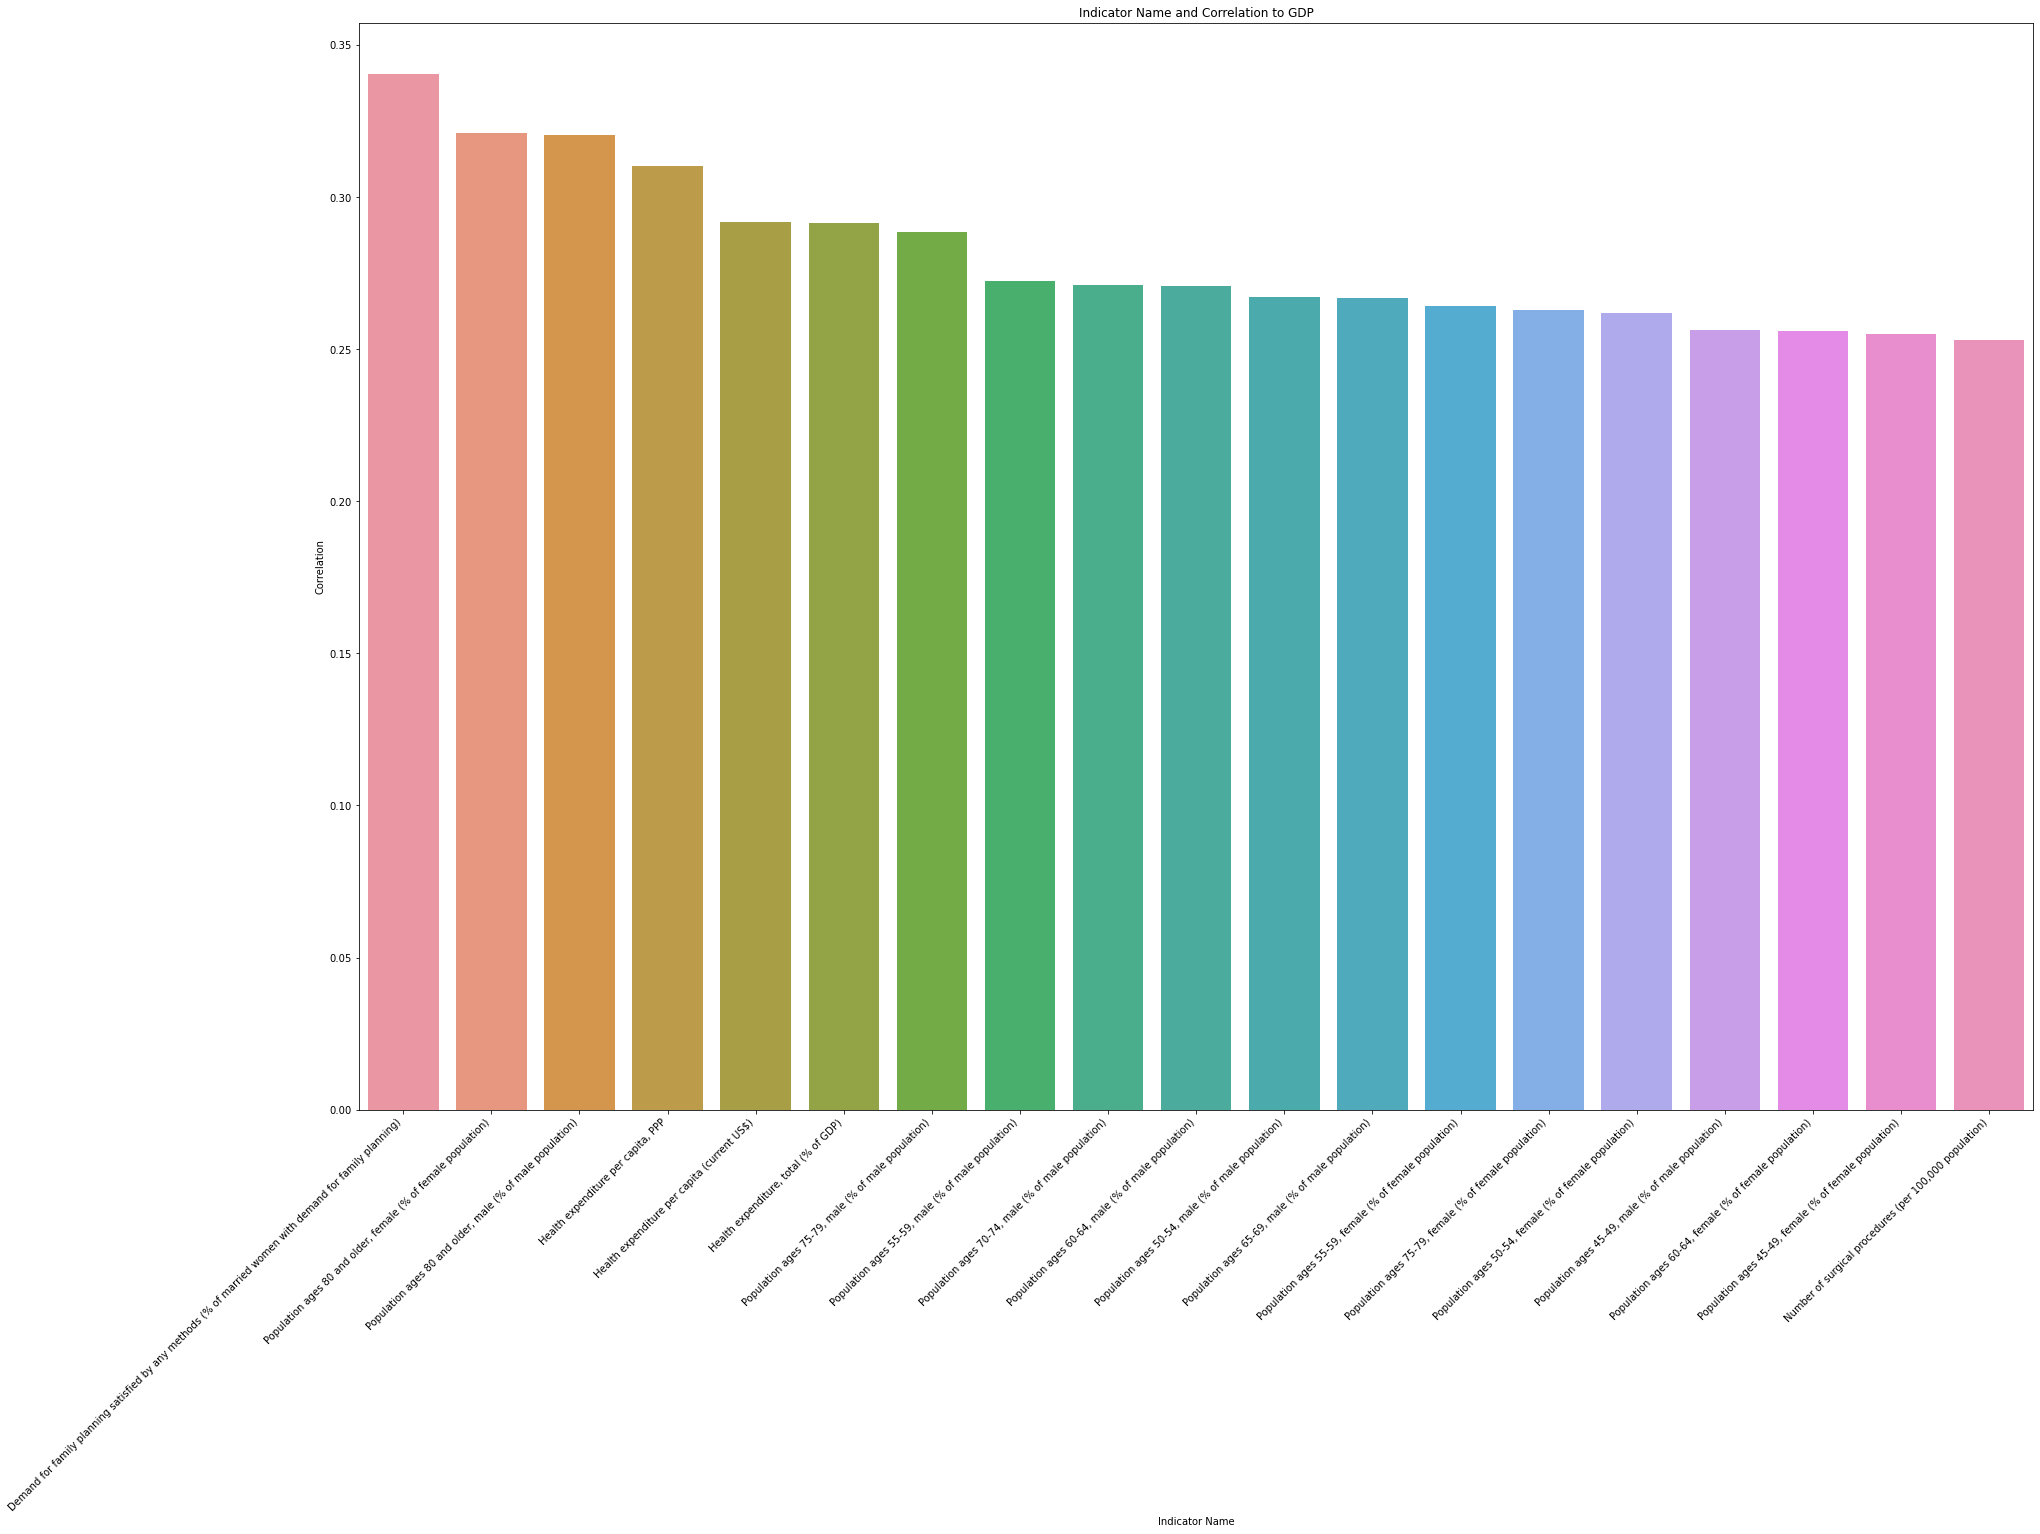

In [40]:
plt.figure(figsize=(30, 20))
ax = sns.barplot(x='Indicator Name', y ='Correlation', data = correlation_ind_names[correlation_ind_names['Correlation'] > 0])
plt.title('Indicator Name and Correlation to GDP')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.xlabel('Indicator Name')
plt.ylabel('Correlation')

plt.show()

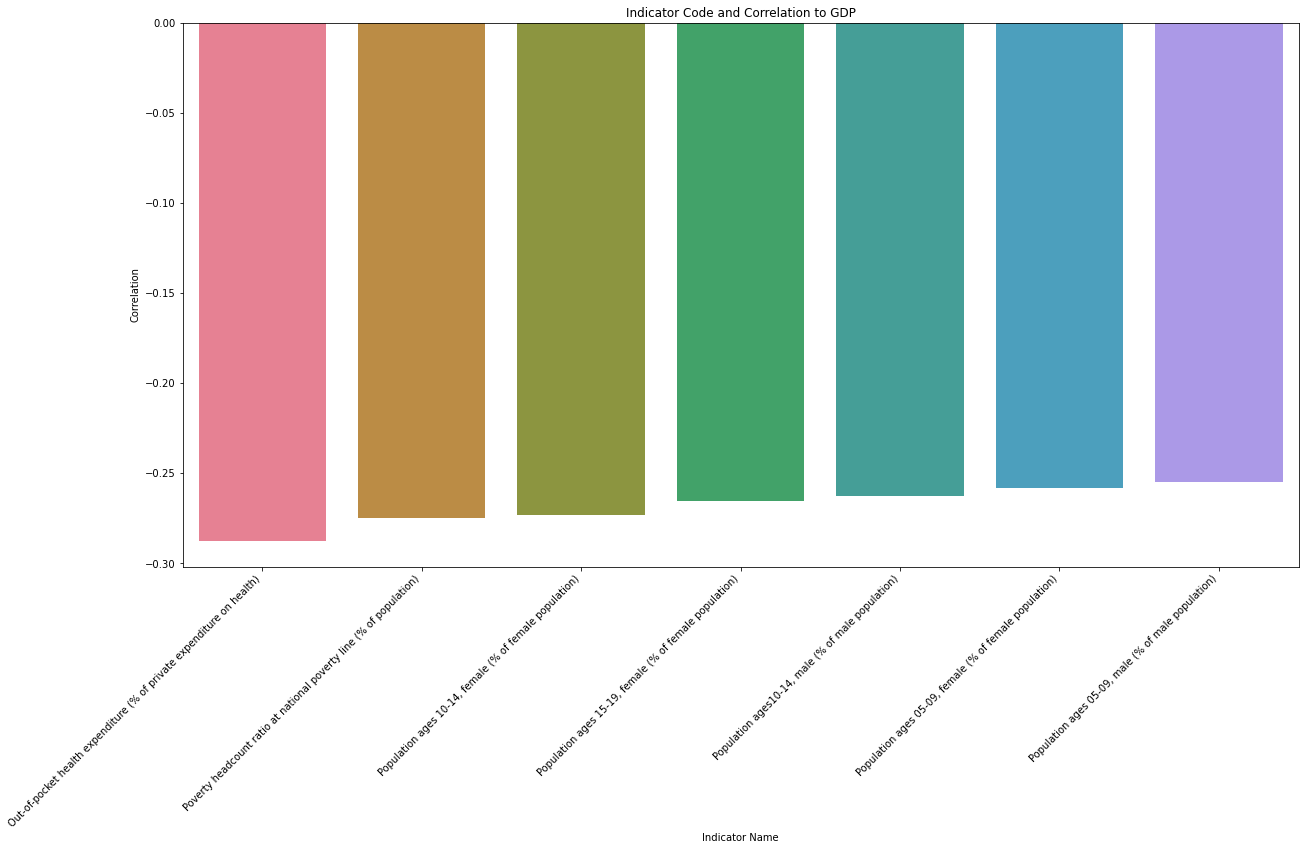

In [41]:
plt.figure(figsize=(20, 10))

ax = sns.barplot(x='Indicator Name', y ='Correlation', data =correlation_ind_names[correlation_ind_names['Correlation'] <=0], palette=sns.color_palette("husl", 8))
plt.title('Indicator Code and Correlation to GDP')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.xlabel('Indicator Name')
plt.ylabel('Correlation')

plt.show()

## Conclusion from gdp-country statitics: Correlation Matrix

#### Positive Correlations

Highest positive correlation was revealed to be demand for family planning satisfied by any methods. We would expect this to be positively correlated with gdp because when families are able to use family planning, they have more income they are able to invest into education and infrastructure.

Many factors appear to involve population percentages of certain aged female and male populations. The population of specific ages can increase number of people who are able to work which increases the labor force of the country. The age that is most highly positively correlated with gdp is 80+, indicating that people in the country are healthier. 

Health expenditure is also moderately correlated with gdp. This is expected because spending mroe on health leads to less premature deaths, which increases the working age and leads to a decrease in illnesses. Number of surgical procedures was also moderately correlated with gdp. This could be explaine by surgeries implying better healthcare available for people, so they are able to be sick less.

#### Negative Correlations

Out of pocket health expenditure has a moderate negative correlation with gdp. This is expected because out-of-pocket expenditure may indicate poverty in the country so that the country is not able to cover some health services. Poeple would be spending a lot of their own money on health care and therefore will have no money left to invest into the country. 

Poverty headcount ratio at national poverty line also have a moderate negative correlation with gdp. This is expected because when country does not have as many resources to give to people, more people will suffer from lower income and therefore poverty. 

The last factors that had a moderate negative correlation with gdp were population ages younger than 19. This is expected because younger people do not have working expereince and some are too young to work. The country has to spend morer money into educating the children. Moreover, when a family grows, they will spend more income to take care of children rather than investing money and time into country's economic growth.

# Correlation Matrix: all variables

In [42]:
correlation_matrix = corr_gdp.corr()

In [43]:
corr_abs = correlation_matrix.abs()

#selecting upper triable of correlation matrix
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

#will drop features that are highly correlated with each other:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

corr_gdp.drop(to_drop, axis=1, inplace=True)

In [44]:
corr_gdp.head()

,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.LITR.FE.ZS,SE.PRM.CMPT.FE.ZS,SE.PRM.CMPT.MA.ZS,SE.PRM.ENRR,SE.PRM.NENR,...,SP.POP.GROW,SP.POP.TOTL.FE.ZS,SP.REG.BRTH.RU.ZS,SP.REG.BRTH.UR.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.UWT.TFRT,gdp_country
26,0,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.611117,51.166911,NaN,NaN,NaN,-0.580604,49.620,-0.641159,NaN,4.054634e+08
27,0,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.299836,51.053610,NaN,NaN,NaN,-1.269118,49.635,-1.330100,NaN,4.876025e+08
28,0,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.233418,50.919331,NaN,NaN,NaN,-1.202958,49.650,-1.263447,NaN,5.964236e+08
29,0,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.073705,50.784834,NaN,NaN,NaN,-0.042878,49.665,-0.104112,NaN,6.953044e+08
30,0,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.812032,50.672588,NaN,NaN,NaN,1.843551,49.681,1.780922,NaN,7.648871e+08


## Null values per feature

In [45]:
nan_feature_df = pd.DataFrame()
features=[]
nan_counts=[]
for feature in corr_gdp.columns:
  features.append(str(feature))
  nan_counts.append(corr_gdp[feature].isna().sum())

nan_feature_df['feature']=features
nan_feature_df['nan_count']=nan_counts

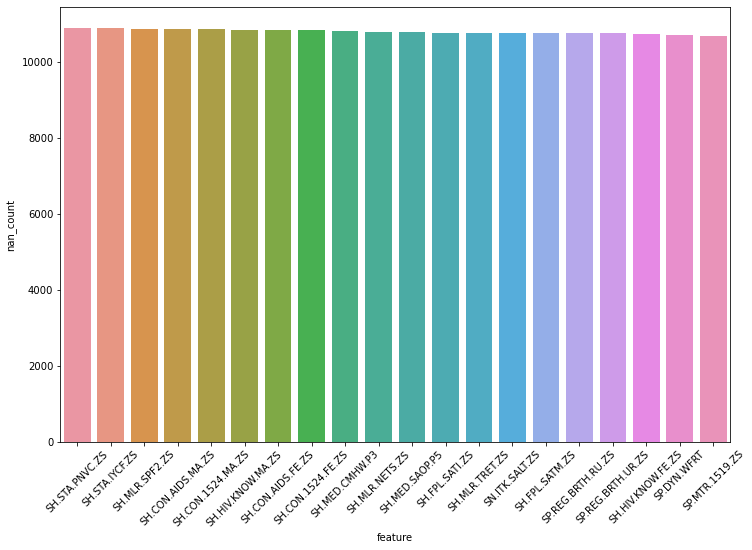

In [46]:
fig, ax = plt.subplots(figsize=(12,8))
nan_feature_df = nan_feature_df.sort_values(by = 'nan_count', ascending=False)
nan_feature_df = nan_feature_df.head(20)
sns.barplot(data=nan_feature_df, x='feature', y='nan_count')
xticks=ax.xaxis.get_major_ticks()
# for i in range(len(xticks)):
#     if i%5!=0:
#         xticks[i].set_visible(False)
ax.set_xticklabels( nan_feature_df['feature'], rotation=45 )        

plt.show()

here is a graph of the percentage of nan values per feature

## Imputing Nan values

As you can see in the graph above, there are a number of Nan values for each feature. To deal with this, we will be using K nearest neighbor imputing to assign Nan values an expected value based on how similar its other features are with data

In [47]:
# Create a KNNImputer object
imputer = KNNImputer()

# Create a parameter grid to search over
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Create a GridSearchCV object
grid_search = GridSearchCV(imputer, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X)

# Print the best parameter setting
print(grid_search.best_params_)

NameError: name 'KNNImputer' is not defined

In [49]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.impute import KNNImputer

X_train, X_test, y_train, y_test = train_test_split(corr_gdp.drop('gdp_country', axis=1), corr_gdp['gdp_country'], test_size=0.2, random_state=42)

# Instantiate the KNNImputer class with k=5
imputer = KNNImputer(n_neighbors=5)

# Fit the imputer to the data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

There are a number of Nan values in each row. We need to 

## Linear Regression

Define a linear regression model using the correlations of indicators as features and GDP as the label

In [50]:
# TO-DO: Import required libraries
from sklearn.linear_model import LinearRegression

# TO-DO: Initialize model with default parameters and fit it on the training set
reg = LinearRegression()
reg.fit(X_train_imputed, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred_log = reg.predict(X_test_imputed)

In [51]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#get metrics to evaluate performance
lin_reg_score = r2_score(y_test, y_pred_log)
mse_score = mean_squared_error(y_test, y_pred_log)

In [52]:
print(lin_reg_score)
print(mse_score)

0.31195759599073325
1.3888780102453136e+25


## Random Forest Regressor

In [53]:
# TO-DO: Import required libraries
import sklearn
from sklearn.ensemble import RandomForestRegressor

# TO-DO: Initialize model with default parameters and fit it on the training set
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train_imputed, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred_rfr = reg_rf.predict(X_test_imputed)

In [55]:

# TO-DO: Find the R-squared score and store the value in `rfr_score`
rfr_score = r2_score(y_test, y_pred_rfr)
mse_score = mean_squared_error(y_test, y_pred_rfr)
print(rfr_score)
print(mse_score)

0.8938097956460792
2.1435486951270858e+24


## Support Vector Machine

Unlike the regression models above, we will create a classification to classify the GDP "category" that a country will fall into. Categories are created by splitting the GDPs into four quartiles - low, low-medium, high-medium, and high. Because this data is so high dimensional, PCA will be used to reduce the number of dimensions

### PCA

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_imputed)
X_test_scale = scaler.transform(X_test_imputed)

# TO-DO: Instantiate and Fit PCA
pca = PCA()
pca.fit(X_train_scale)

PCA()

In [68]:
explained_variance_ratios=pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios) 

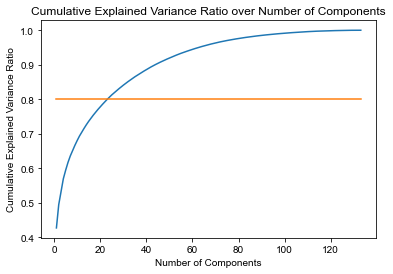

In [69]:
plot=sns.lineplot(x = [x for x in range(1,len(cum_evr)+1)], y=cum_evr)
plot2=sns.lineplot(x = [x for x in range(1,len(cum_evr)+1)], y = [0.8 for y in range(len(cum_evr))])
plot.set(xlabel ="Number of Components", ylabel = "Cumulative Explained Variance Ratio", title ='Cumulative Explained Variance Ratio over Number of Components')

sns.set(rc={'figure.figsize':(8,6)})

In [70]:
n = 30
pca = PCA(n_components=n)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [75]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

corr_df_classification = corr_df.copy()

# Create GDP categories based on quartiles
y_train_buckets = pd.qcut(y_train, q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])
y_test_buckets = pd.qcut(y_test, q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])

# Convert the GDP category labels to numerical values
label_encoder = LabelEncoder()
y_train_buckets = label_encoder.fit_transform(y_train_buckets)
y_test_buckets = label_encoder.fit_transform(y_test_buckets)

# Create an SVM classifier with a linear kernel
clf = SVC(kernel='rbf')

# Train the classifier on the training data
clf.fit(X_train_pca, y_train_buckets)

# Make predictions on the test data
y_pred_svc = clf.predict(X_test_pca)

# Convert the numerical category labels back to string labels
y_test_str = label_encoder.inverse_transform(y_test_buckets)
y_pred_str = label_encoder.inverse_transform(y_pred_svc)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test_buckets, y_pred_svc)

# Print the accuracy
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.729


the sigmoid kernel above had an accuracy of around 28%. Linear was around 50%, and rbf was the highest, with 73%

## Map visualization

In [57]:
!pip install plotly

     |████████████████████████████████| 15.3 MB 985 kB/s eta 0:00:01


In [64]:
import plotly.express as px
fig = px.choropleth(corr_gdp[corr_gdp['Year']==2015], locations="Country Code", color='gdp_country', hover_name='Country Code', projection='natural earth')
fig.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier with a linear kernel
clf = SVC(kernel='linear')

# Train the classifier on the training data
clf.fit(X_train_imputed, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.3f}")

ValueError: Unknown label type: 'continuous'

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Identify the indicators with high correlation with GDP
corr_75th_percentile = np.percentile(abs(sort_melted['Correlation']), 75)
high_corr_features = sort_melted[abs(sort_melted['Correlation']) > corr_75th_percentile]['Indicator Code']

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(corr_gdp.drop('gdp_country', axis=1), corr_gdp['gdp_country'], test_size=0.2, random_state=42)

# Impute missing values in the training and testing data
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Define the HistGradientBoostingRegressor model
model = HistGradientBoostingRegressor()

# Train the model using the imputed training data
model.fit(X_train_imputed, y_train)

# Evaluate the performance of the model on the imputed testing data
score = model.score(X_test_imputed, y_test)
print("R-squared:", score)

ImportError: cannot import name 'HistGradientBoostingRegressor' from 'sklearn.ensemble' (/Users/aashvimanakiwala/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/__init__.py)

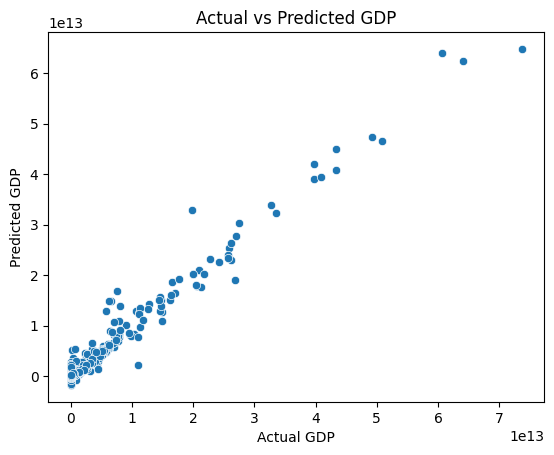

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict GDP using the trained model on the testing data
y_pred = model.predict(X_test_imputed)

# Create a scatter plot of actual vs predicted GDP values
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual GDP')
plt.ylabel('Predicted GDP')
plt.title('Actual vs Predicted GDP')
plt.show()

## Random Forest Regressor

## Clustering

Our last approach will be to use clustering to classify what bracket of GDP a country falls in. While this will not give an accurate GDP like the prediction models above, this fits the purpose of our project, which is to predict the welfare of a nation based on its socioeconomic and cultural metrics. It suffices to group certain ranges of GDPs and predict what group a particular country falls under

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Extract the features we want to include in the PCA
X = melt_nutr_df[['Year', 'Value']]

In [ ]:
# Standardize the features by subtracting the mean and scaling to unit variance
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to the standardized data
pca.fit(X_std)

# Transform the data to the new coordinate system
X_pca = pca.transform(X_std)

# Create a new DataFrame with the transformed data and the country labels
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Country'] = melt_nutr_df['Country Name']

# Print the explained variance of each principal component
print(pca.explained_variance_ratio_)

[0.51810576 0.48189424]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Aggregate the values for duplicate entries
melt_nutr_df_avg = melt_nutr_df.groupby(['Indicator Name', 'Country Name'])['Value'].mean().reset_index()
melt_nutr_df_avg

,Indicator Name,Country Name,Value
0,% of females ages 15-49 having comprehensive c...,Afghanistan,1.500000
1,% of females ages 15-49 having comprehensive c...,Albania,11.333333
2,% of females ages 15-49 having comprehensive c...,Algeria,10.700000
3,% of females ages 15-49 having comprehensive c...,Argentina,45.300000
4,% of females ages 15-49 having comprehensive c...,Armenia,19.033333
...,...,...,...
41798,Women's share of population ages 15+ living wi...,Vietnam,19.073451
41799,Women's share of population ages 15+ living wi...,World,49.354686
41800,Women's share of population ages 15+ living wi...,"Yemen, Rep.",32.095671
41801,Women's share of population ages 15+ living wi...,Zambia,56.782600
